a few steps:
    
    -find representative nodes 
            1. feature extraction (all the followees)  
            2. feature selection  
                modify here 10/31/2016
                (1) instead of get the top 300 most counts, now weed out 1 and 2 get all followees. query their total followers
                (2) instead of penalize by total followers, consider penalize by a prior distribution 1 - p(target users)
     my feeling on this section, there wont be many improvement available. Cuz we only have positive features, feature selection methods (mutual information, chi2, f-test wont work, already tested)
            
    -classification/ranking based on the feature
    -testing
    
    -addition: besides follower/followee relationship, whatelse information can we add into this model
    

In [1]:
import tweepy
import json
from time import sleep
import pickle
import re
from os import listdir
from os.path import isfile, join
import sys
import math
%matplotlib inline
import matplotlib.pyplot as plt

# configuration

In [2]:
path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\CS597\\twitterMining\\'
initialSet_path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\'
path_test2 = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\test2\\'

In [3]:
config = {}
config['KEYS'] = {'consumer_key': ['mVJcyNN5qFyk7GdBJvENVc329', 'anqjETSjwaDqA9LBt0MGwub60','vDnzvZFFwXFgI2ftQxYWV2XZo',
                                  'sAkNaJxJWgPilhidaNJ48kmCo','tO2Bzbkexyf57LSF6aJwACXfs'],
                  'consumer_secret': ['DbXUXB7EN77HmzQahobHeTPSWgcNI9t8kKzDoe5twfTORnjXxf',\
                                       'AGTAiJhOrb2gPSbW1F5Rclu0Ns7pTZthPhJ3i7ySFNWwdheqim',\
                                     '5HxLPob3kGqgauc5HuNszFw0uoLjsK3JHD0IqUNEVbNAIVdRKQ',\
                                      'dPcVmoYaEGhsWC5djrEFsjfNdO8DmFecmSnBRjL63y0Sg9pCtl',
                                     'OIEIE1Pu01eTieDffG13kJM78spAPHZtKk2IZ1yGkU0eoKvVxn'],
                  'access_token': ['707770026573561856-Vfqm0iXrsBvFL2prQMQ2Gzu9eawWYIj',\
                                    '707770026573561856-diXgIsR0UCYM3CHYCUoU38hcp8Qk8Pj',\
                                  '707770026573561856-9BcLFzjLrkVdxeG0Z3dmqYhsCDqUQ2t',\
                                  '707770026573561856-Sua2gUtlWTxTik70a0dUba0SvayeQgU',\
                                  '707770026573561856-Oi1nNb4Ih0SJyizIwToY3PhjLymGkcl'],
                  'access_token_secret': ['HSMqS4YkDBcB6mm9JL3vd6VeKlkKmNdMxmJ0inJQwNhXS',\
                                           'GnqrY0AoeOuK7cgaF2yRBmcJGcc814bBIONMREN8gU7xu',\
                                         'e2OfQnQGnweLygFxJRFCUa9PZhOZXyCcaEipMpnlmABqj',\
                                         'Stj2TQtwsrTQFkdronpZDUyrl9g3slZjEMxgIYznbmSzy',\
                                         'Cp3d4xKdTfPyJq6y7uLeRLv77kTjZmEIpGYtiWrrqvK6i']
                 }
''
# later add {if it's not exist then write, otherwise skip}
with open(path + "CONFIG_PATH.pickle", 'wb+') as f:
        pickle.dump(config, f)

In [4]:
consumer_key = config['KEYS']['consumer_key']    # list
consumer_secret = config['KEYS']['consumer_secret']
access_token = config['KEYS']['access_token']
access_token_secret = config['KEYS']['access_token_secret']

# test whether the ranking predictive model works

<p>seperate them into groups: baseline(twitter stream), every 300? </p>
<p>we should see there is a decline in matching accuracy in the two aspects: eg.football + chicago </p>

<p> 1. chicago </p>
<b> ratio = # user from chicago / # number of user provide their location </b>



In [53]:
# a bag of pre-defined locations that represent chicago
chicago = ['chicago','Arlington Heights', 'Aurora', 'Berwyn', 'Bolingbrook', 'Cicero','Des Plaines', 'Elgin','Evanston', 'Gary', 'Hammond',
           'Hoffman Estates', 'Joliet', 'Kenosha', 'Mount Prospect','Naperville', 'Oak Lawn', 'Oak Park', 'Orland Park',
           'Palatine', 'Schaumburg','Skokie','Tinley Park','Waukegan','Wheaton']#,', IL','Illinois']

In [54]:
def print_ratio(candidate_list,location_list, area, interval,path,title,verbose=False):
    
    ratio = []
    
    for i in range(math.floor(len(candidate_list)/interval)):
        if verbose == True:
            print('bin:',interval*(i), '~', interval*(i+1))
        
        target_count = 0
        general_count = 0
        no_count = 0
        
        for cand in candidate_list[interval*(i): interval*(i+1)]:
            if location_list[cand[0]] != 'NaN' and location_list[cand[0]] != None:
                general_count += 1
                #print('g',general_count,loc)
                flag = False
                for a in area:
                    if location_list[cand[0]].lower().find(a.lower()) != -1: 
                        # matches one of the place that stands for chicago
                        flag = True
            
                if flag == True:
                    target_count += 1
                    #print('t',target_count,loc)
            else:
                no_count += 1                
        
        if verbose == True:
            print("% of people provide location : ", general_count/(interval)*100, '%')
        
        if general_count !=0:
            if verbose == True:
                print("% of people from chicago who provided location: ", target_count/general_count*100, '%\n')
            ratio.append(target_count / general_count)
        else:
            if verbose == True:
                print("invalid bin\n")
            ratio.append('NaN')
            
    
    x = range(len(ratio))
    y = ratio

    fig, axes = plt.subplots(figsize=(5,5))

    axes.bar(x,y)
    axes.set_xlabel('ranked group with an interval of ' + str(interval), fontsize = 8)
    axes.set_ylabel('percentage of user from chicago',fontsize = 8)
    axes.set_title(title,fontsize = 10)

    plt.show()  
    
    fig.savefig(path + title + ' ' + str(interval) + '.png')
            

    return ratio

In [55]:
with open(path_test2 + 'location_list_sp1.pickle','rb') as f:
    location_dict_sp1 = pickle.load(f)
with open(path_test2 + 'location_list_sp2.pickle','rb') as f:
    location_dict_sp2 = pickle.load(f)

# test cosine similarity rank (weighted)

In [56]:
with open(path_test2 + 'weighted_sim_rank_sp2.pickle','rb') as f:
    candidate_sim = pickle.load(f)

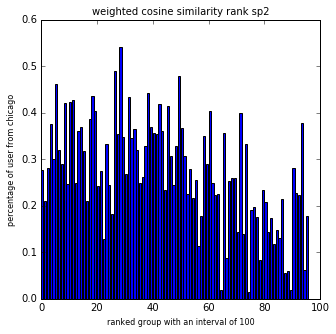

In [57]:
ratio = print_ratio(candidate_sim, location_dict_sp2, chicago, interval = 100, path = path_test2,\
                    title = 'weighted cosine similarity rank sp2',verbose = False)
#ratio = print_ratio(candidate_sim, location_dict_sp1, chicago, interval = 500, path = path_test1,\
#                    title = 'weighted cosine similarity rank sp1',verbose = False)
#ratio = print_ratio(candidate_sim, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
#                    title = 'weighted cosine similarity rank sp1',verbose = False)

# test unweighted cosine similarity

In [58]:
with open(path_test2 + 'unweighted_sim_rank_sp2.pickle','rb') as f:
    u_candidate_sim = pickle.load(f)

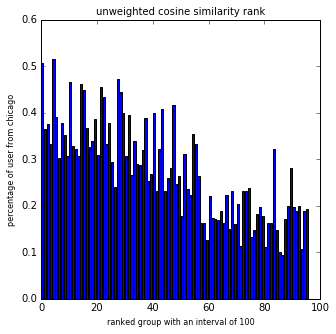

In [59]:
ratio = print_ratio(u_candidate_sim, location_dict_sp2, chicago, interval = 100, path = path_test2,\
                    title = 'unweighted cosine similarity rank',verbose = False)
#ratio = print_ratio(u_candidate_sim, location_dict_sp1, chicago, interval = 500, path = path_test1,\
#                    title = 'unweighted cosine similarity rank',verbose = False)
#ratio = print_ratio(u_candidate_sim, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
#                    title = 'unweighted cosine similarity rank',verbose = False)

# test NB ranking w/ penalty

In [60]:
with open(path_test2 + 'NB_rank_sp2.pickle','rb') as f:
    candidate_NB = pickle.load(f)
with open(path_test2 + 'NB_p_rank_sp2.pickle','rb') as f:
    candidate_NB_p = pickle.load(f)    

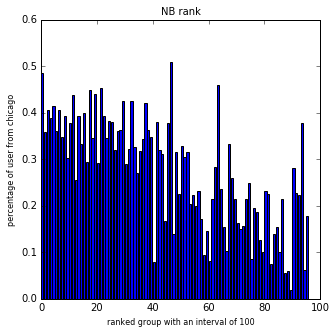

In [61]:
ratio = print_ratio(candidate_NB, location_dict_sp2, chicago, interval = 100, path = path_test2,\
                    title = 'NB rank',verbose = False)
#ratio = print_ratio(candidate_NB, location_dict_sp1, chicago, interval = 500, path = path_test1,\
#                    title = 'NB rank',verbose = False)
#ratio = print_ratio(candidate_NB, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
#                    title = 'NB rank',verbose = False)

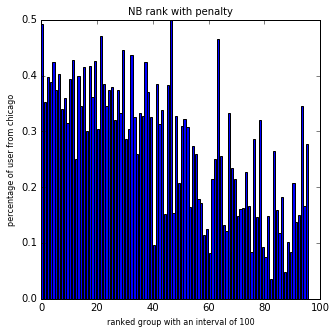

In [62]:
ratio = print_ratio(candidate_NB_p, location_dict_sp2, chicago, interval = 100, path = path_test2,\
                    title = 'NB rank with penalty',verbose = False)
#ratio = print_ratio(candidate_NB_p, location_dict_sp1, chicago, interval = 500, path = path_test1,\
#                    title = 'NB rank with penalty',verbose = False)
#ratio = print_ratio(candidate_NB_p, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
#                    title = 'NB rank with penalty',verbose = False)

# Average Precision on a ranked list AVP(L)  
<img src = 'AVP.png'>

In [63]:
def av_precision(candidate_list,location_list, area):
    
    relevant = 0
    total_score = 0
    count = 0
    
    for cand in candidate_list:
            
            if location_list[cand[0]] != 'NaN' and location_list[cand[0]] != None:
                count += 1  #people who provide the ground truth
                
                flag = False
                for a in area:
                    if location_list[cand[0]].lower().find(a.lower()) != -1: 
                        # matches one of the place that stands for chicago (Relevant)
                        flag = True
                if flag == True:
                    relevant += 1
                    total_score  += relevant/count
    print('rel:', relevant)
    avp = total_score/relevant
    
    return avp

In [64]:
w_sim_score = av_precision(candidate_sim,location_dict_sp2, chicago)
u_sim_score = av_precision(u_candidate_sim,location_dict_sp2,chicago)
NB_score = av_precision(candidate_NB,location_dict_sp2,chicago)
NB_p_score = av_precision(candidate_NB_p,location_dict_sp2,chicago)
print("average precision sample 1 (test on location match)")
print('weighted cosine similarity method:\t',w_sim_score)
print('unweighted cosine similarity method:\t',u_sim_score)
print('Naive Bayes method:\t\t\t',NB_score)
print('Naive Bayes with penalty method:\t',NB_p_score)

rel: 1475
rel: 1475
rel: 1475
rel: 1475
average precision sample 1 (test on location match)
weighted cosine similarity method:	 0.3182393824612498
unweighted cosine similarity method:	 0.36263811829947895
Naive Bayes method:			 0.36235571239628134
Naive Bayes with penalty method:	 0.3623017286967897


# test classification (use sample 1 location list)

1. Naive Bayes classification

In [19]:
def clf_chicago_percentage(id_list,location_list,area):
    
    general_count = 0
    target_count = 0
    
    for id in id_list:
        
        if location_list[id] != None and location_list[id] != 'NaN':
            general_count += 1
            
            flag = False
            for a in area:
                if location_list[id].lower().find(a.lower()) != -1: 
                    
                    # matches one of the place that stands for chicago
                    flag = True
            
            if flag == True:
                target_count += 1  #
                # print(location_list[id])
                    
    #print("how many user provide location: ", general_count)
    #print("how many user are from target area: ", target_count)
    #print("accuracy = ", target_count/general_count)
    
    return target_count, general_count-target_count

In [20]:
def metrics(TP, FP, TN, FN):
       
    acc = (TP+TN)/(TP+FP+FN+TN)
    TPR = TP/(TP+FN)
    TNR = TN/(FP+TN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2* precision * recall/(precision + recall)
    
    print("\nacc = (TP + TN)/ (T+ P) = ", (TP+TN)/(TP+FP+FN+TN))
    print("TPR = TP/(TP + FN) = ", TP/(TP+FN))
    print("TNR = TN/(FP + TN) = ", TN/(FP+TN))
    print('precision = TP/(TP + FP) = ', TP/(TP+FP))
    print('recall = TP/(TP + FN) = ', TP/(TP+FN))
    print('F1 score = ', 2*TP/(2*TP +FP + FN))
    
    metrics_list = [precision,recall,F1, TPR, TNR, acc]
    
    return metrics_list

# Naive Bayes

In [29]:
new_path = 'C:/Users/chenwang/Documents/courses/FA16/CS597/twitterMining/InitialSet/Football/location/test2/undersampling/'

In [35]:
with open(new_path + 'clf_NB_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(new_path + 'clf_NB_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)
print('Naive Bayes')
TP, FP= clf_chicago_percentage(rel_id_test,location_dict_sp2,chicago)
FN, TN = clf_chicago_percentage(irrel_id_test,location_dict_sp2,chicago)
metrics(TP, FP, TN, FN)

Naive Bayes

acc = (TP + TN)/ (T+ P) =  0.689687267311988
TPR = TP/(TP + FN) =  0.2922033898305085
TNR = TN/(FP + TN) =  0.8401334359763921
precision = TP/(TP + FP) =  0.4089184060721063
recall = TP/(TP + FN) =  0.2922033898305085
F1 score =  0.34084618426255436


[0.4089184060721063,
 0.2922033898305085,
 0.3408461842625543,
 0.2922033898305085,
 0.8401334359763921,
 0.689687267311988]

# Decision Tree

In [36]:
with open(new_path + 'clf_DT_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(new_path + 'clf_DT_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)
print('decision tree')
TP, FP= clf_chicago_percentage(rel_id_test,location_dict_sp2,chicago)
FN, TN = clf_chicago_percentage(irrel_id_test,location_dict_sp2,chicago)
metrics(TP, FP, TN, FN)

decision tree

acc = (TP + TN)/ (T+ P) =  0.7056962025316456
TPR = TP/(TP + FN) =  0.31661016949152543
TNR = TN/(FP + TN) =  0.852963818321786
precision = TP/(TP + FP) =  0.44903846153846155
recall = TP/(TP + FN) =  0.31661016949152543
F1 score =  0.3713717693836978


[0.44903846153846155,
 0.31661016949152543,
 0.3713717693836978,
 0.31661016949152543,
 0.852963818321786,
 0.7056962025316456]

# KNN (neighbor = 1)

In [37]:
with open(new_path + 'clf_KNN_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(new_path + 'clf_KNN_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)
print('1-NN')
TP, FP= clf_chicago_percentage(rel_id_test,location_dict_sp2,chicago)
FN, TN = clf_chicago_percentage(irrel_id_test,location_dict_sp2,chicago)
metrics(TP, FP, TN, FN)

1-NN

acc = (TP + TN)/ (T+ P) =  0.6874534623976173
TPR = TP/(TP + FN) =  0.29694915254237286
TNR = TN/(FP + TN) =  0.8352578906851424
precision = TP/(TP + FP) =  0.40555555555555556
recall = TP/(TP + FN) =  0.29694915254237286
F1 score =  0.34285714285714286


[0.40555555555555556,
 0.29694915254237286,
 0.34285714285714286,
 0.29694915254237286,
 0.8352578906851424,
 0.6874534623976173]

# Gradient Boosting Classification

In [38]:
with open(new_path + 'clf_GBC_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(new_path + 'clf_GBC_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)
print('gradient boosting classification')
TP, FP= clf_chicago_percentage(rel_id_test,location_dict_sp2,chicago)
FN, TN = clf_chicago_percentage(irrel_id_test,location_dict_sp2,chicago)
metrics(TP, FP, TN, FN)

gradient boosting classification

acc = (TP + TN)/ (T+ P) =  0.7222635889798957
TPR = TP/(TP + FN) =  0.14711864406779662
TNR = TN/(FP + TN) =  0.9399538106235565
precision = TP/(TP + FP) =  0.4811529933481153
recall = TP/(TP + FN) =  0.14711864406779662
F1 score =  0.22533748701973


[0.4811529933481153,
 0.14711864406779662,
 0.22533748701973005,
 0.14711864406779662,
 0.9399538106235565,
 0.7222635889798957]

# Neural Network classficiation (Hidden layer 100? all default setting)

In [39]:
with open(new_path + 'clf_NNW_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(new_path + 'clf_NNW_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)
print('neural network')
TP, FP= clf_chicago_percentage(rel_id_test,location_dict_sp2,chicago)
FN, TN = clf_chicago_percentage(irrel_id_test,location_dict_sp2,chicago)
metrics(TP, FP, TN, FN)

neural network

acc = (TP + TN)/ (T+ P) =  0.7069992553983618
TPR = TP/(TP + FN) =  0.27864406779661016
TNR = TN/(FP + TN) =  0.8691301000769823
precision = TP/(TP + FP) =  0.44625407166123776
recall = TP/(TP + FN) =  0.27864406779661016
F1 score =  0.34307178631051755


[0.44625407166123776,
 0.27864406779661016,
 0.3430717863105175,
 0.27864406779661016,
 0.8691301000769823,
 0.7069992553983618]

# comparing ranking with classification (pairwise comparison)

In [40]:
def rank2clf(rank,rank_mehtod, clf_pos, clf_neg, clf_method, location_dict):
    
    # rank method: NB, NB_p, sim, w_sim
    # clf method: NB, DT, KNN, GBC, NNW, ground_truth
    if clf_method == 'ground truth':
        percentage = 827/3732
    else:
        percentage = len(positive)/(len(positive) + len(negative))
    
    index = math.floor(len(rank)*percentage)
    
    r_pos = [rank[i][0] for i in range(index)]
    r_neg = [rank[i][0] for i in range(index,len(rank))]
    
    print('rank method:', rank_mehtod)
    TP, FP = clf_chicago_percentage(r_pos,location_dict,chicago)   
    FN, TN = clf_chicago_percentage(r_neg,location_dict,chicago)
    score1 = metrics(TP, FP, TN, FN)
    print('--------------------------------------------------------------')
    
    if clf_method !='ground truth':
        print('clf method:', clf_method)
        TP1, FP1 = clf_chicago_percentage(positive,location_dict,chicago)   
        FN1, TN1 = clf_chicago_percentage(negative,location_dict,chicago)    
        score2 = metrics(TP1, FP1, TN1, FN1)
        
    return None

In [43]:
with open(new_path + 'clf_NB_test_rel.pickle','rb') as f:
    positive = pickle.load(f)
with open(new_path + 'clf_NB_test_irrel.pickle','rb') as f:
    negative = pickle.load(f)
with open(path_test2 + 'NB_rank_sp2.pickle','rb') as f:
    rank = pickle.load(f)
rank2clf(rank,'NB', positive, negative,'NB',location_dict_sp2)

rank method: NB

acc = (TP + TN)/ (T+ P) =  0.6811243484735666
TPR = TP/(TP + FN) =  0.2569491525423729
TNR = TN/(FP + TN) =  0.8416730818578394
precision = TP/(TP + FP) =  0.38052208835341367
recall = TP/(TP + FN) =  0.2569491525423729
F1 score =  0.3067583974099555
--------------------------------------------------------------
clf method: NB

acc = (TP + TN)/ (T+ P) =  0.6963886820551005
TPR = TP/(TP + FN) =  0.2664406779661017
TNR = TN/(FP + TN) =  0.859122401847575
precision = TP/(TP + FP) =  0.4171974522292994
recall = TP/(TP + FN) =  0.2664406779661017
F1 score =  0.32519652461729415


In [44]:
with open(path_test2 + 'NB_rank_sp2.pickle','rb') as f:
    rank = pickle.load(f)
rank2clf(rank,'NB', positive, negative,'ground truth',location_dict_sp2)

rank method: NB

acc = (TP + TN)/ (T+ P) =  0.6706999255398362
TPR = TP/(TP + FN) =  0.3050847457627119
TNR = TN/(FP + TN) =  0.8090839107005389
precision = TP/(TP + FP) =  0.3768844221105528
recall = TP/(TP + FN) =  0.3050847457627119
F1 score =  0.3372049456725365
--------------------------------------------------------------


In [45]:
with open(path_test2 + 'NB_p_rank_sp2.pickle','rb') as f:
    rank = pickle.load(f)
rank2clf(rank,'NB with missing feature', positive, negative,'ground truth',location_dict_sp2)

rank method: NB with missing feature

acc = (TP + TN)/ (T+ P) =  0.6706999255398362
TPR = TP/(TP + FN) =  0.3050847457627119
TNR = TN/(FP + TN) =  0.8090839107005389
precision = TP/(TP + FP) =  0.3768844221105528
recall = TP/(TP + FN) =  0.3050847457627119
F1 score =  0.3372049456725365
--------------------------------------------------------------


In [46]:
with open(path_test2 + 'unweighted_sim_rank_sp2.pickle','rb') as f:
    rank = pickle.load(f)
rank2clf(rank,'unweighted similairty', positive, negative,'ground truth',location_dict_sp2)

rank method: unweighted similairty

acc = (TP + TN)/ (T+ P) =  0.672933730454207
TPR = TP/(TP + FN) =  0.30847457627118646
TNR = TN/(FP + TN) =  0.810880164228894
precision = TP/(TP + FP) =  0.38171140939597314
recall = TP/(TP + FN) =  0.30847457627118646
F1 score =  0.34120734908136485
--------------------------------------------------------------


In [47]:
with open(path_test2 + 'weighted_sim_rank_sp2.pickle','rb') as f:
    rank = pickle.load(f)
rank2clf(rank,'weighted similairty', positive, negative,'ground truth',location_dict_sp2)

rank method: weighted similairty

acc = (TP + TN)/ (T+ P) =  0.6442665673864483
TPR = TP/(TP + FN) =  0.2976271186440678
TNR = TN/(FP + TN) =  0.7754683089556069
precision = TP/(TP + FP) =  0.3340943683409437
recall = TP/(TP + FN) =  0.2976271186440678
F1 score =  0.31480817497310865
--------------------------------------------------------------
